## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_dir_J,mwc_s_dir_W,mwc_s_dir_Wstar,mwc_s_dir_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [3]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J()

Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:173: RuntimeWarning: invalid value encountered in scalar divide
  self.gamma_all[iz, in0, in1, 1] = ( (Xi-xbar) * (Yi-ybar) * W ).sum() / (  (Xi-xbar) * (Xi-ybar) * W ).sum()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:33: RuntimeWarning: invalid value encountered in power
  Xi_pow = np.power( Xi_arg , gamma[2])


Errors: nan 0.7647866612447728 nan 1.3169098026616672 1
Errors: nan 0.7647866612447728 nan 1.3169098026616672 1
EJinv -61.98974821375929
EJderiv -27.4203380754778
EJinv diff 1j 2s: 2.3146504679077733
EJinv diff 1 sen: 0.42957514676669667
EJinv diff 2 sen: 0.769824179989087
EJinv -47.61804769417228
EJderiv -25.716038299498077
EJinv diff 1j 2s: 0.9433037841784819
EJinv diff 1 sen: 0.39633957853163343
EJinv diff 2 sen: 1.1880955669222832
EJinv -38.300573730261675
EJderiv -23.09082320800064
EJinv diff 1j 2s: 0.7277553936668036
EJinv diff 1 sen: 0.37729064366652965
EJinv diff 2 sen: 2.6116087515251234
EJinv -31.513308866167854
EJderiv -19.309737425905585
EJinv diff 1j 2s: 0.5914935677380435
EJinv diff 1 sen: 0.36170885734882885
EJinv diff 2 sen: 4.9985629556868005
EJinv -25.92513255824145
EJderiv -14.461073424024878
EJinv diff 1j 2s: 0.6081108213781827
EJinv diff 1 sen: 0.3474477355924539
EJinv diff 2 sen: 0.8422625271334655
EJinv -20.74806395115452
EJderiv -8.773338451358697
EJinv diff 1j 

In [4]:
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep)=mwc.J_sep(mwc_J,mwc_W)

Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)
Errors: 0.1291162263992648 8.960381642576291e-12 0.13576909578804183 1.8774573111784068e-15 1
Errors: 0.0 8.960381642576291e-12 0.13576909578804183 1.8774573111784068e-15 1
EJinv 14.637706372735236
EJderiv 15.926073161346423
EJinv diff 1j 2s: 0.07625010197658248
EJinv diff 1 sen: 0.20824171630562302
EJinv diff 2 sen: 0.12646827839351255
sep borders 0.0 0.0
EJinv 14.637665309666694
EJderiv 15.92602548503838
EJinv diff 1j 2s: 0.07624990191089501
EJinv diff 1 sen: 0.20824194203606777
EJinv diff 2 sen: 0.12646857249757773
sep borders 0.0 0.0
EJinv 14.637625080753018
EJderiv 15.925978775259862
EJinv diff 1j 2s: 0.07624970571039348
EJinv diff 1 sen: 0.20824216316317756
EJinv diff 2 sen: 0.1264688606027034
sep borders 0.0 0.0
EJinv 14.637585668858026
EJderiv 15.925933012440794
EJinv diff 1j 2s: 0.07624951330110925
EJinv diff 1 sen: 0.20824237978124163
EJinv diff 2 sen: 0.12646914283117058
sep borders 0.0 0.0
EJinv 14.637547057547177
EJderiv 

In [5]:
(mwc_s_dir_J,mwc_s_dir_W,mwc_s_dir_Wstar,mwc_s_dir_sep)=mwc.J_sep_dir(mwc_J,mwc_W)

Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)
Errors: 0.1291162263992648 8.960381642576291e-12 0.13576909578804183 1.8774573111784068e-15 1
Errors: 0.0 8.960381642576291e-12 0.13576909578804183 1.8774573111784068e-15 1
EJinv 14.637706372735236
EJderiv 15.926073161346423
EJinv diff 1j 2s: 0.07625010197658248
EJinv diff 1 sen: 0.20824171630562302
EJinv diff 2 sen: 0.12646827839351255
sep borders 0.0 0.0
EJinv 14.637665309666694
EJderiv 15.92602548503838
EJinv diff 1j 2s: 0.07624990191089501
EJinv diff 1 sen: 0.20824194203606777
EJinv diff 2 sen: 0.12646857249757773
sep borders 0.0 0.0
EJinv 14.637625080753018
EJderiv 15.925978775259862
EJinv diff 1j 2s: 0.07624970571039348
EJinv diff 1 sen: 0.20824216316317756
EJinv diff 2 sen: 0.1264688606027034
sep borders 0.0 0.0
EJinv 14.637585668858026
EJderiv 15.925933012440794
EJinv diff 1j 2s: 0.07624951330110925
EJinv diff 1 sen: 0.20824237978124163
EJinv diff 2 sen: 0.12646914283117058
sep borders 0.0 0.0
EJinv 14.637547057547177
EJderiv 

In [ ]:
from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

In [ ]:
mwc_J[0,1,1,:]-mwc_J[0,0,1,:]

In [ ]:
mwc_n0[0,0,2,:]

In [ ]:
mwc.N_grid1[1]

In [ ]:
(mwc_Wstar[0,0,1,:]-mwc_W[0,0,1,:,1])-(mwc_Wstar[0,0,0,:]  -mwc_W[0,0,0,:,1])

In [ ]:
mwc_n0[0,1,0,:] #there are full hirings (0,4) and (4,0), but those are intenterpretable as we don't actually have a good value for J(4,4)

In [ ]:
mwc_n1[0,0,0,:]

In [ ]:
mwc_J[0,1,0,:]

In [ ]:
((mwc_J[p.z_0-1,1,3,50]-mwc_J[p.z_0-1,1,1,50])/2+mwc.N_grid[2]*mwc.rho_grid[50]*(mwc_W[p.z_0-1,1,3,50,1]-mwc_W[p.z_0-1,1,1,50,1])/2+mwc.w_grid[50]-mwc.fun_prod_onedim[p.z_0-1]*mwc.prod_1d[p.z_0-1,1,3,50])/(p.beta*mwc_pc[p.z_0-1,1,3,50])

# Plots

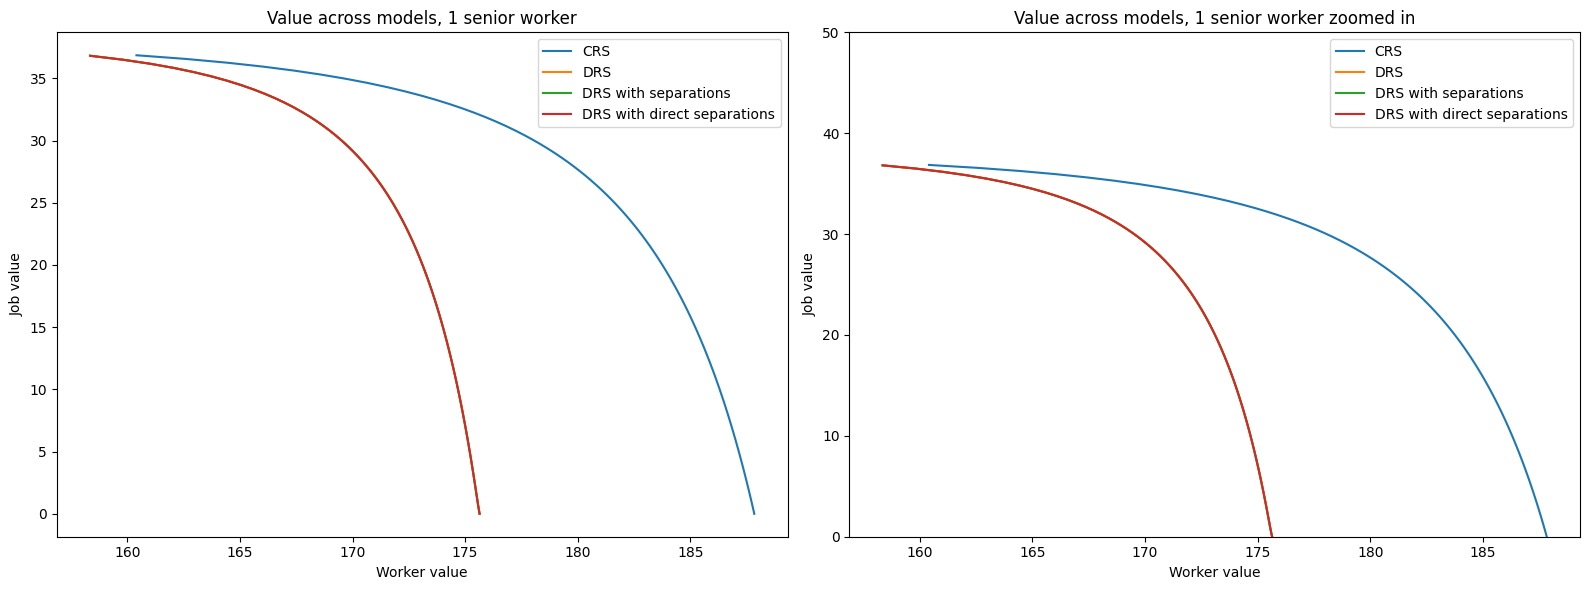

In [6]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_W,mwc_J/mwc.N_grid[1],mwc_s_W,mwc_s_J,mwc_s_dir_W,mwc_s_dir_J,0)

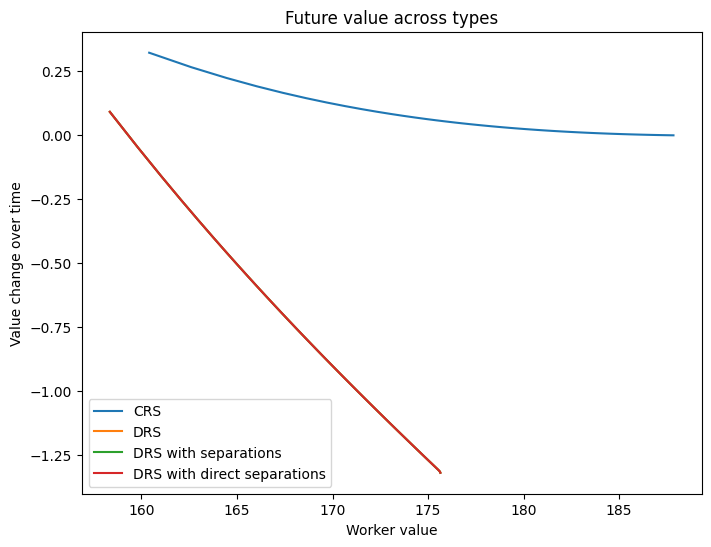

In [7]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_W,mwc_Wstar,mwc_s_W,mwc_s_Wstar,mwc_s_dir_W,mwc_s_dir_Wstar,0)

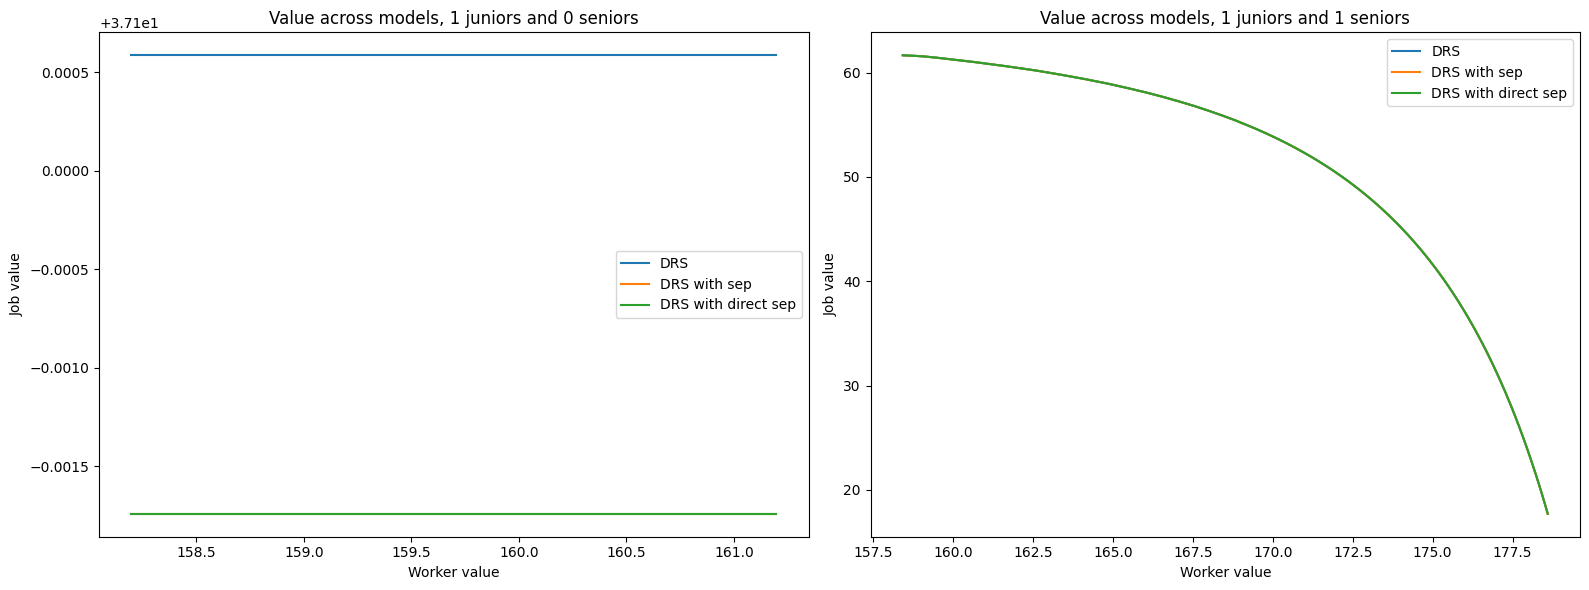

In [8]:
plts.ValueComparison(1,0,1,1,cc_W,cc_J,mwc_W,mwc_J,mwc_s_W,mwc_s_J,mwc_s_dir_W,mwc_s_dir_J,0)

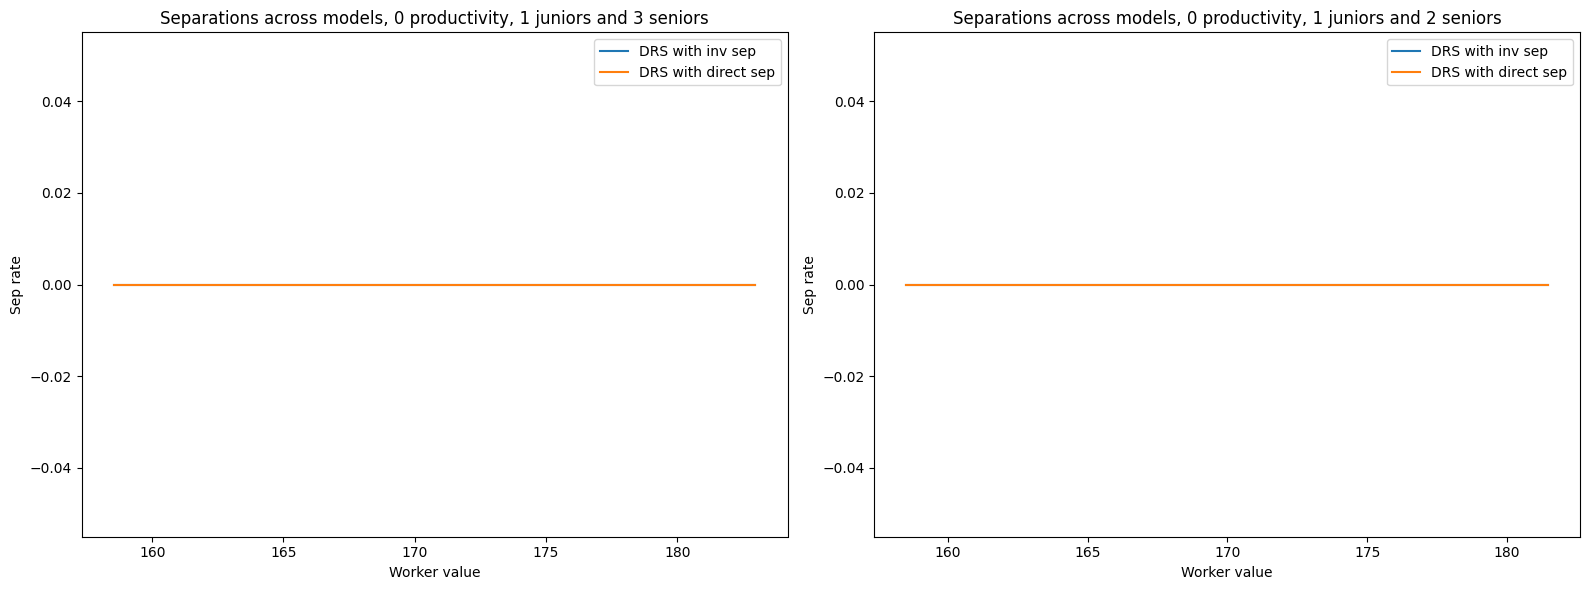

In [10]:
plts.sep(0,p.z_0-1,1,3,1,2,mwc_s_W,mwc_s_sep,mwc_s_dir_W,mwc_s_dir_sep)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=1
sen=1
if mwc_s_W is not None:        
    plt.plot(mwc_s_W[p.z_0-1, jun, sen, :, 1], mwc_s_sep[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwc_s_dir_W is not None:        
    plt.plot(mwc_s_dir_W[p.z_0-1, jun, sen, :, 1], mwc_s_dir_sep[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Separations across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Sep rate')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_s_dir_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_s_dir_sep[:,3,0,:]))

In [ ]:
np.max(mwc_s_dir_sep[:,1,1,:])

In [ ]:
mwc_s_dir_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations